<a href="https://colab.research.google.com/github/joannawqy/ECON323/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Packages and Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("merged_data.csv")

In [3]:
df.head()

,country,Code,ContinentCode,year,GDP per capita constant 2010 dollars,Capital investment as percent of GDP,Capital investment billion USD,Household consumption as percent of GDP,Household consumption billion USD,Labor force million people,...,Government spending billion USD,Population growth percent,Happiness Index 0 (unhappy) - 10 (happy),Economic growth: the rate of change of real GDP,Gross Domestic Product billions of 2010 U.S. dollars,Unemployment rate,Exports of goods and services billion USD,Exports of goods and services annual growth,Current account balance billion USD,ranking index
0,Argentina,ARG,SA,2017,13595.04,18.21,117.22,66.74,429.55,19.58,...,113.90,1.04,6.60,2.82,598.8,8.35,72.86,2.62,-31.15,116
1,Argentina,ARG,SA,2018,13105.40,16.61,87.19,69.47,364.59,20.10,...,82.95,1.02,6.39,-2.62,583.1,9.22,75.77,0.65,-27.08,126
2,Argentina,ARG,SA,2019,12716.22,14.21,63.63,66.13,296.09,20.61,...,73.63,0.99,6.09,-2.00,571.5,9.84,80.26,9.75,-3.49,128
3,Argentina,ARG,SA,2020,11341.27,14.13,54.48,63.79,245.94,19.41,...,65.12,0.97,5.93,-9.94,514.6,11.46,64.04,-17.71,3.12,128
4,Argentina,ARG,SA,2021,12402.49,17.47,85.14,60.89,296.69,21.19,...,77.19,0.95,5.97,10.40,568.1,8.74,87.87,9.22,6.71,133


In [4]:
nans = df.isna().sum()
nan_columns = nans[nans > 0]
nan_columns

ContinentCode    18
dtype: int64

# Data Exploratory Analysis

## Correlation Analysis

<ipython-input-7-a340f3ec8605>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


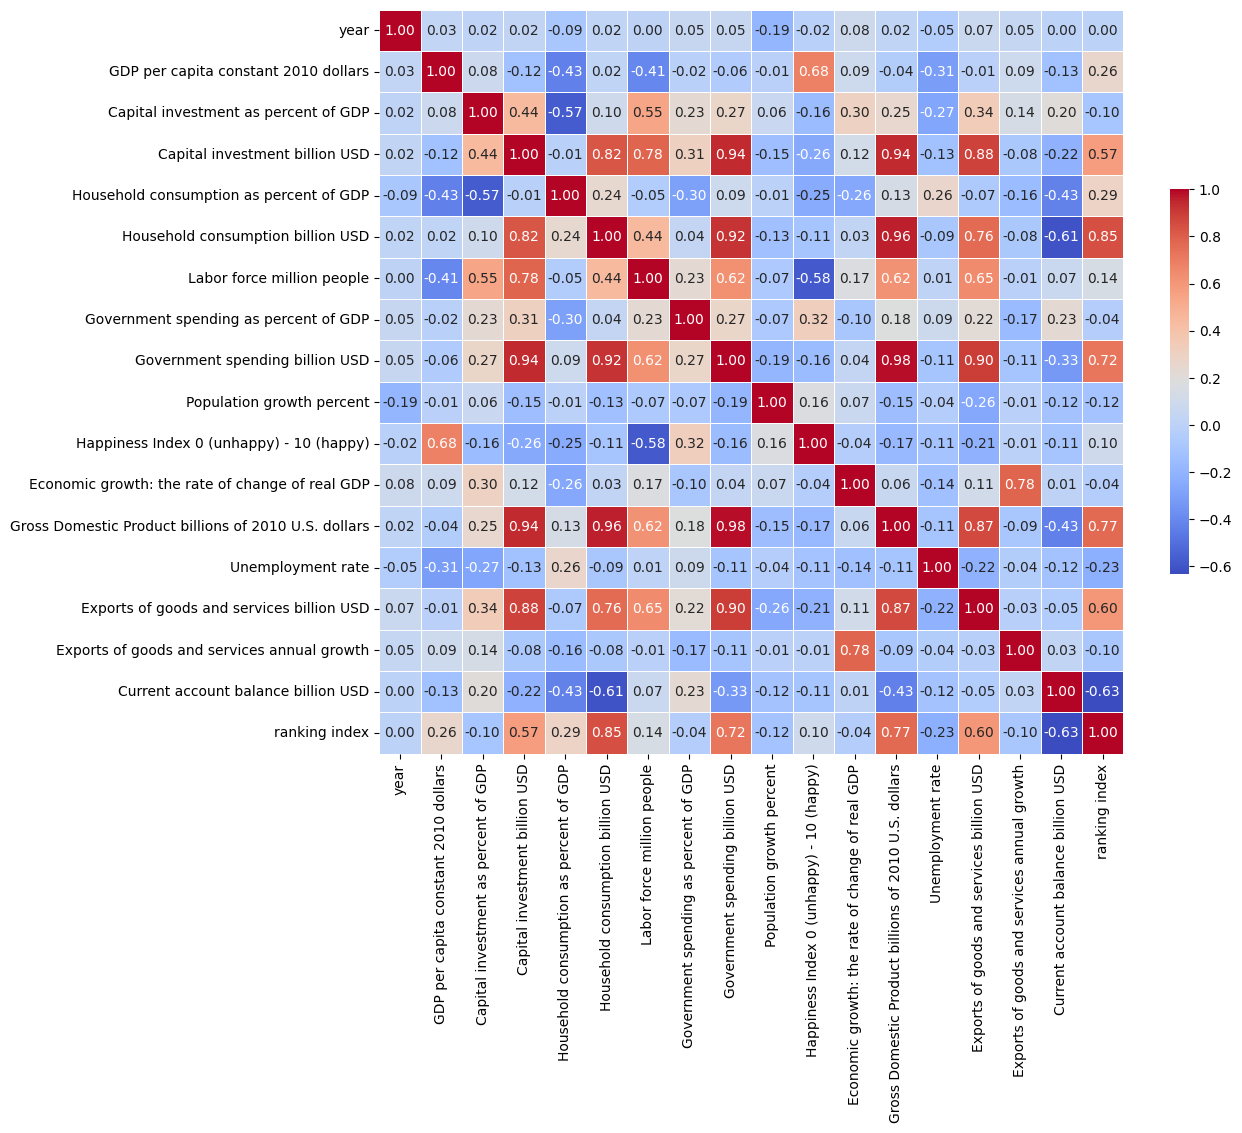

In [7]:
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [8]:
high_corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

# Filter out pairs of the same variable (correlation of 1) and lower correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]
high_corr_pairs = high_corr_pairs[high_corr_pairs >= 0.5]

# Output the pairs with high correlation
high_corr_pairs

Gross Domestic Product billions of 2010 U.S. dollars  Government spending billion USD                         0.982074
Government spending billion USD                       Gross Domestic Product billions of 2010 U.S. dollars    0.982074
Gross Domestic Product billions of 2010 U.S. dollars  Household consumption billion USD                       0.961335
Household consumption billion USD                     Gross Domestic Product billions of 2010 U.S. dollars    0.961335
Capital investment billion USD                        Gross Domestic Product billions of 2010 U.S. dollars    0.940435
Gross Domestic Product billions of 2010 U.S. dollars  Capital investment billion USD                          0.940435
Capital investment billion USD                        Government spending billion USD                         0.936655
Government spending billion USD                       Capital investment billion USD                          0.936655
                                                

## Predictors Time Series

In [9]:
import plotly.graph_objs as go

variables = [
    "Capital investment billion USD",
    "Household consumption billion USD",
    "Government spending billion USD",
    "Gross Domestic Product billions of 2010 U.S. dollars",
    "Exports of goods and services billion USD",
    "Current account balance billion USD"
]

for variable in variables:

  fig = go.Figure()

  for country in df['country'].unique():
      df_country = df[df['country'] == country]
      fig.add_trace(go.Scatter(
          x=df_country['year'],
          y=df_country[variable],
          name=country,
          visible=True
      ))

  buttons = [
      dict(label='All Countries',
          method='update',
          args=[{'visible': [True] * len(df['country'].unique())},  # Set all traces to visible
                {'title': f'{variable} Over Years by Country'}])
  ]

  for country in df['country'].unique():
      visible_list = [country == c for c in df['country'].unique()]
      buttons.append(
          dict(label=country,
              method='update',
              args=[{'visible': visible_list},
                    {'title': f'{variable} Over Years: {country}'}])
      )

  fig.update_layout(
      updatemenus=[
          go.layout.Updatemenu(
              buttons=buttons,
              direction='down',
              pad={'r': 10, 't': 10},
              showactive=True,
              x=0,
              xanchor='left',
              y=1.1,
              yanchor='top',
              bgcolor='#AAAAAA',
              bordercolor='#FFFFFF',
              font=dict(size=11, color='#000000')
          )
      ],
      title=f'{variable} Over Years by Country'
  )

  fig.update_xaxes(title_text='Year')
  fig.update_yaxes(title_text=f'{variable}')

  fig.show()

## Mapping of Rank Index

In [10]:
import plotly.express as px

# Determine the fixed range for the color scale
# This could be based on the min and max of the "ranking index" or a range you decide
color_scale_min = df['ranking index'].min()
color_scale_max = df['ranking index'].max()

# Create the map with a fixed color scale
fig = px.choropleth(
    df,
    locations="Code",
    color="ranking index",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale=px.colors.sequential.Plasma,  # Using blue color scale
    range_color=[color_scale_min, color_scale_max],  # Set the fixed range for the color scale
    projection="natural earth",
    title="Country Ranking Index Over Years"
)

# Set the layout for the slider
fig.layout.sliders[0].pad.t = 10

# Show the figure
fig.show()

## Individual Regression

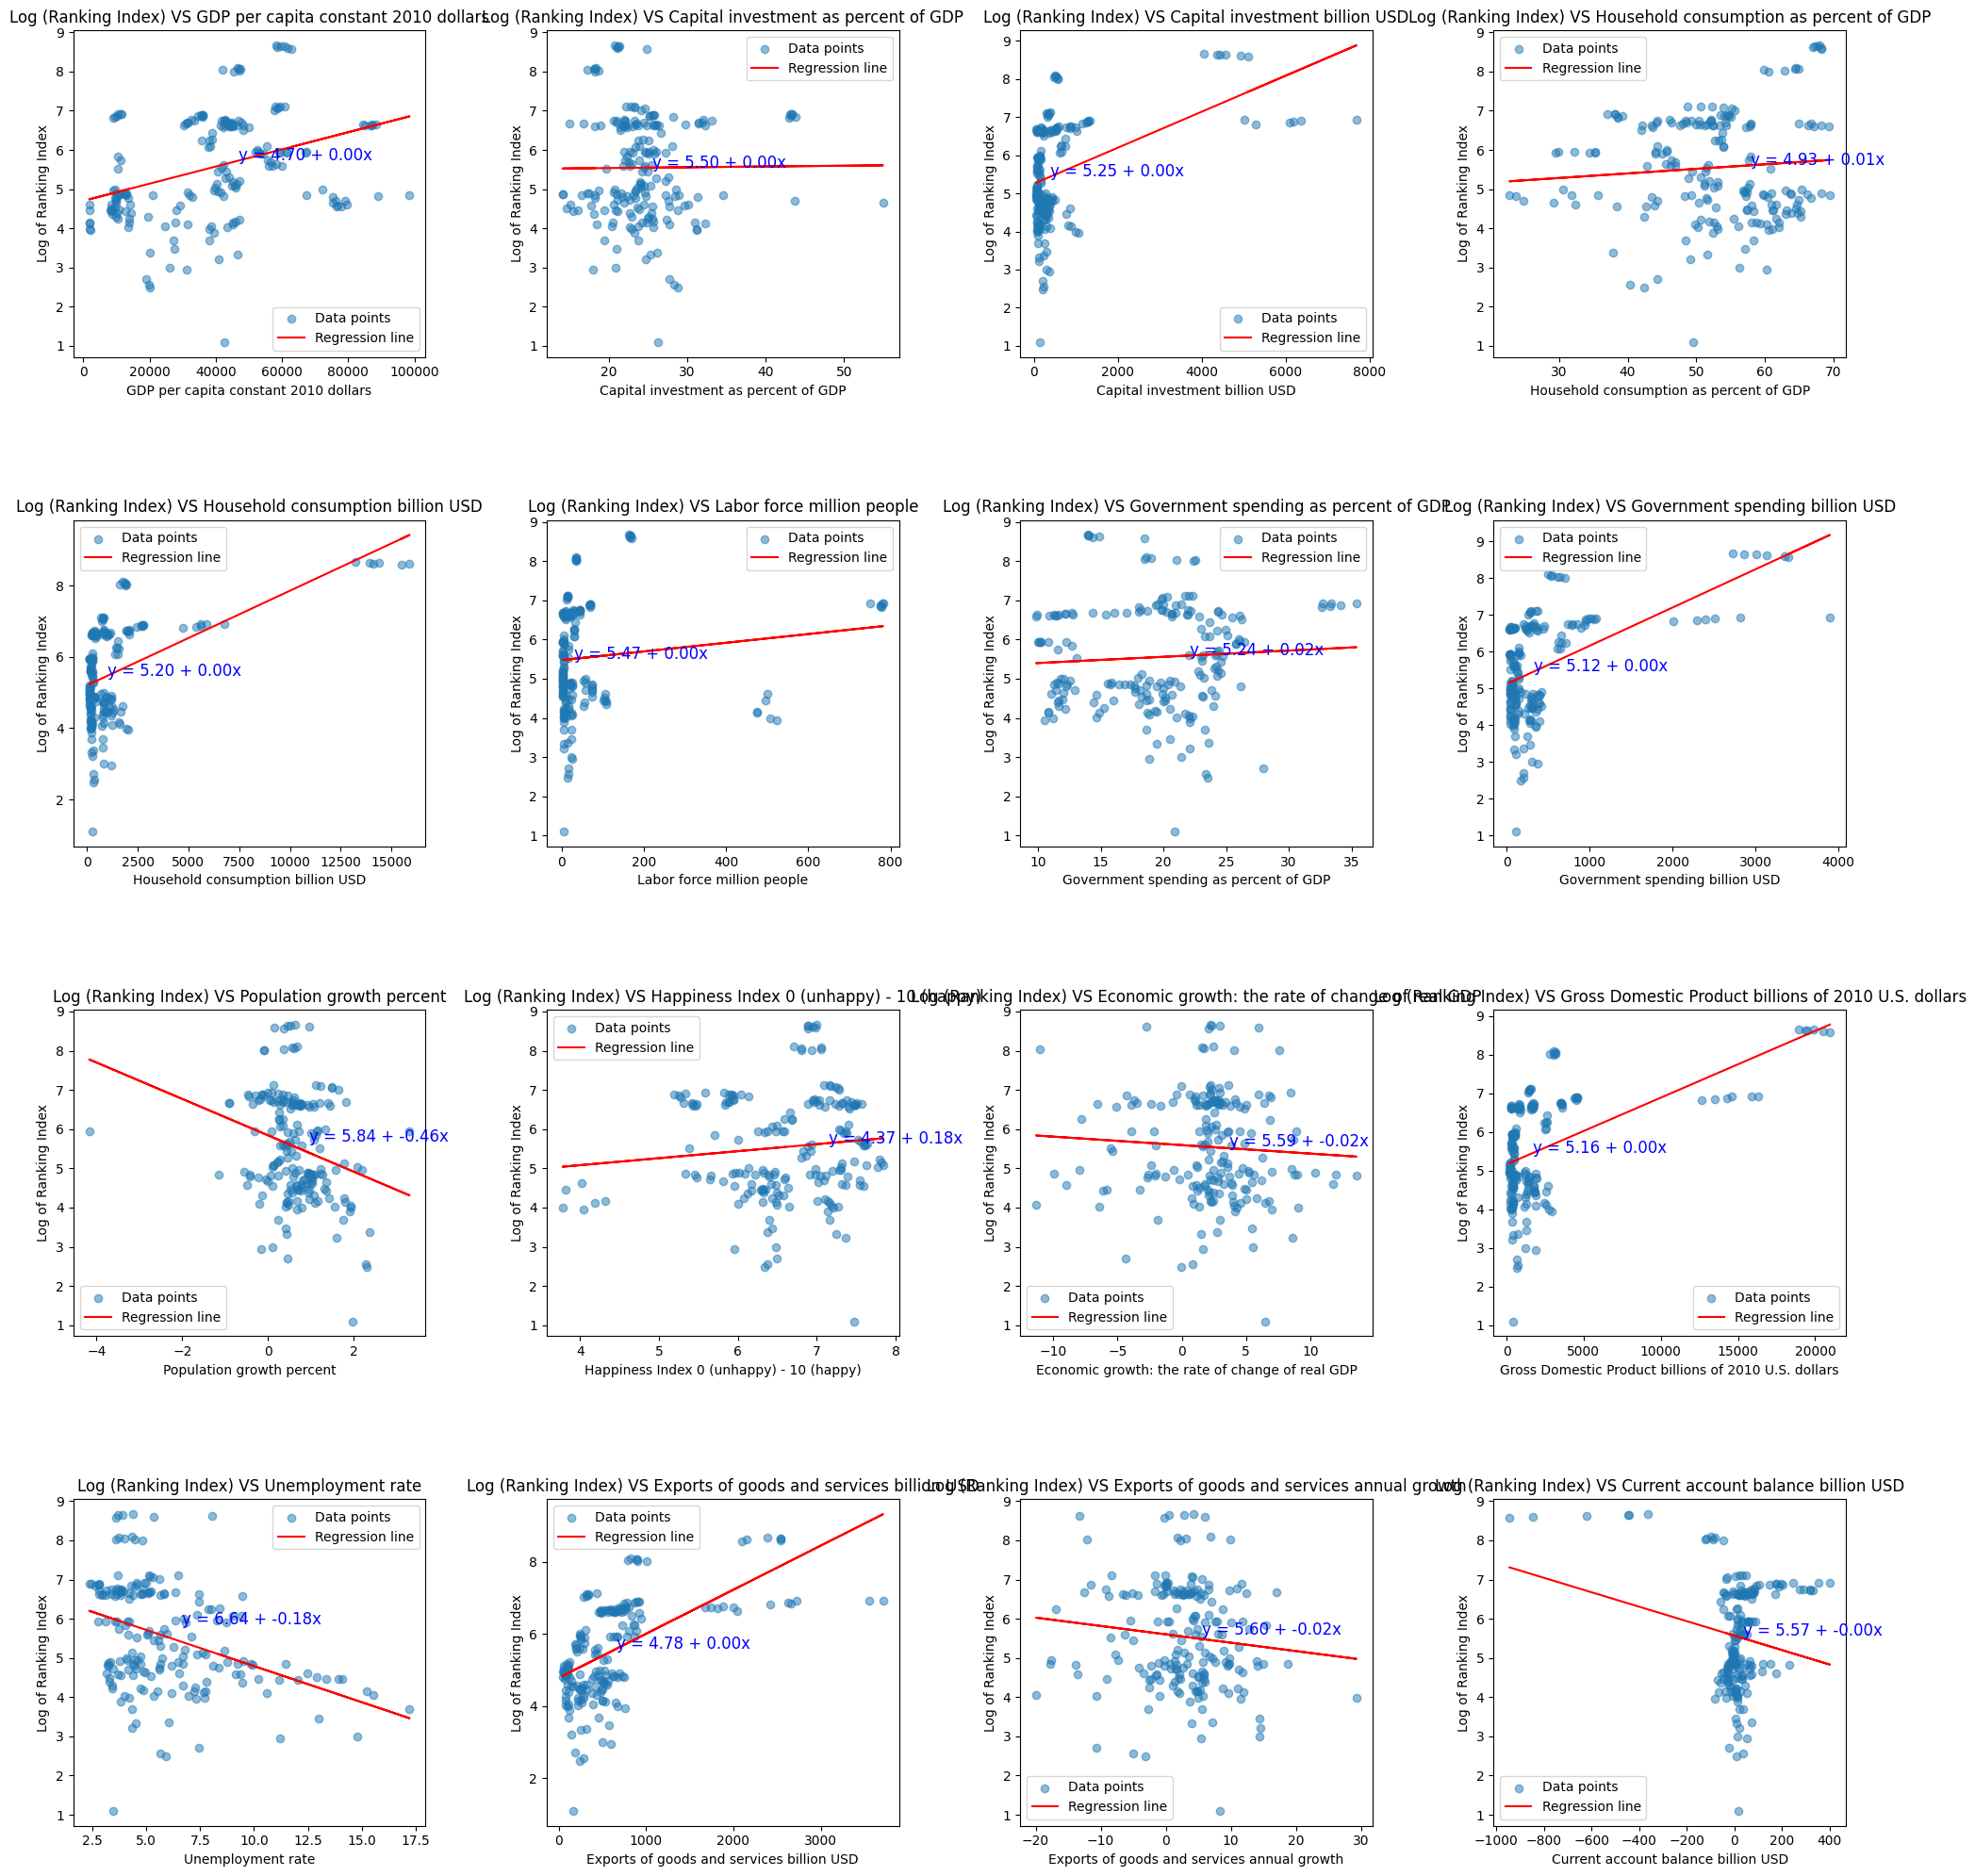

In [12]:
import statsmodels.api as sm

# Assuming df is your DataFrame and 'ranking index' is your response variable

# Drop the non-predictor columns as well as the target variable 'ranking index'
columns_to_drop = ['country', 'Code', 'ContinentCode', 'year', 'ranking index']
X = df.drop(columns_to_drop, axis=1)

# Apply log transformation to y, ensure no zero or negative values in 'ranking index'
y = df['ranking index']
y_log = np.log(y + 1)  # Adding 1 to avoid taking log of zero

# Create a 4x4 matrix of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot individual regressions with the log-transformed y
for i, column in enumerate(X.columns):
    # Add a constant term to the predictor
    X_col = sm.add_constant(df[column])

    # Fit the model using the log-transformed y
    model = sm.OLS(y_log, X_col, missing='drop').fit()  # 'missing=drop' to handle NaNs

    # Scatter plot
    axes[i].scatter(df[column], y_log, alpha=0.5, label='Data points')

    # Regression line
    predicted_values = model.predict(X_col)
    axes[i].plot(df[column], predicted_values, color='red', label='Regression line')

    # Get the equation of the line
    intercept, slope = model.params
    line_eq = f"y = {intercept:.2f} + {slope:.2f}x"

    # Plot the equation somewhere on the plot
    x_val = np.percentile(df[column].dropna(), 70)  # A value from the 70th percentile, dropping NaNs
    y_val = np.percentile(predicted_values, 70)  # Corresponding y value
    axes[i].text(x_val, y_val, line_eq, fontsize=12, color='blue')

    # Labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Log of Ranking Index')
    axes[i].set_title(f'Log (Ranking Index) VS {column}')
    axes[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

for j in range(i+1, 16):
    fig.delaxes(axes[j])


# Modeling

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


In [ ]:
X = df.drop(['country', 'Code', 'ContinentCode', 'year', 'ranking index'], axis=1)
y = np.log(df['ranking index'])

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

## Random Forest For Feature Selection

In [22]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_scaled, y)

RandomForestRegressor()

In [23]:
importances = rf.feature_importances_

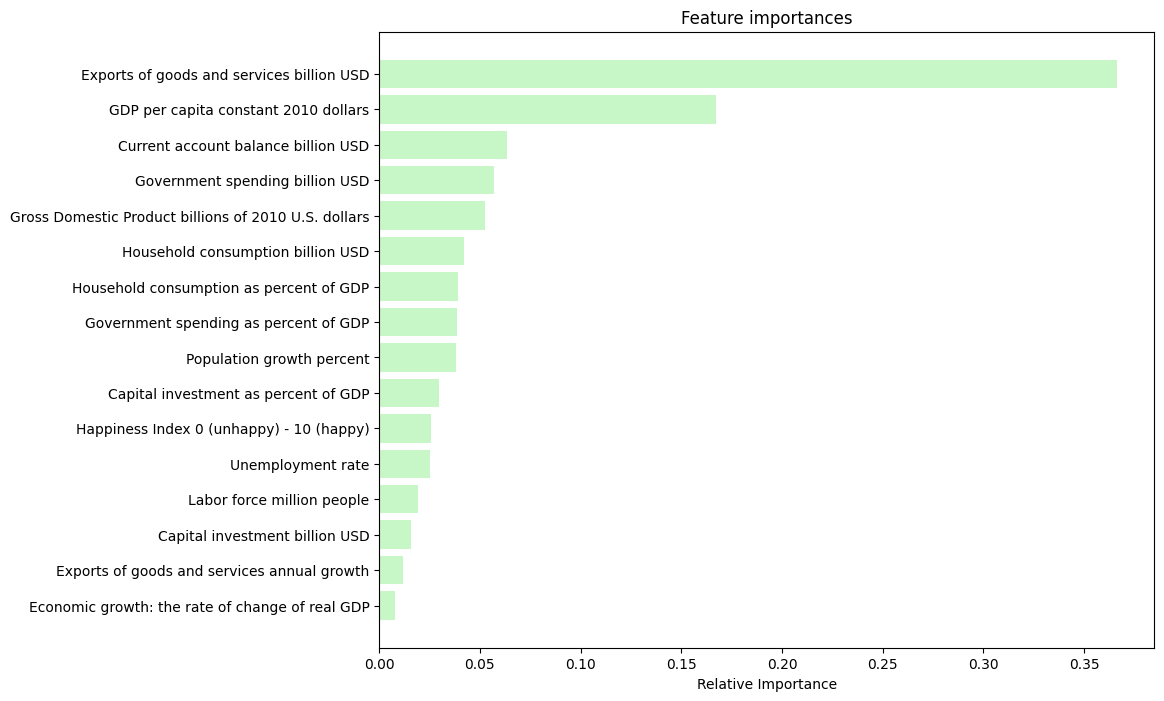

In [26]:
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="lightgreen", alpha = 0.5, align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Lasso

In [ ]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

These features are assigned with 0 coefficient: Index(['Capital investment billion USD', 'Household consumption billion USD',
       'Labor force million people', 'Government spending billion USD',
       'Gross Domestic Product billions of 2010 U.S. dollars',
       'Current account balance billion USD'],
      dtype='object')


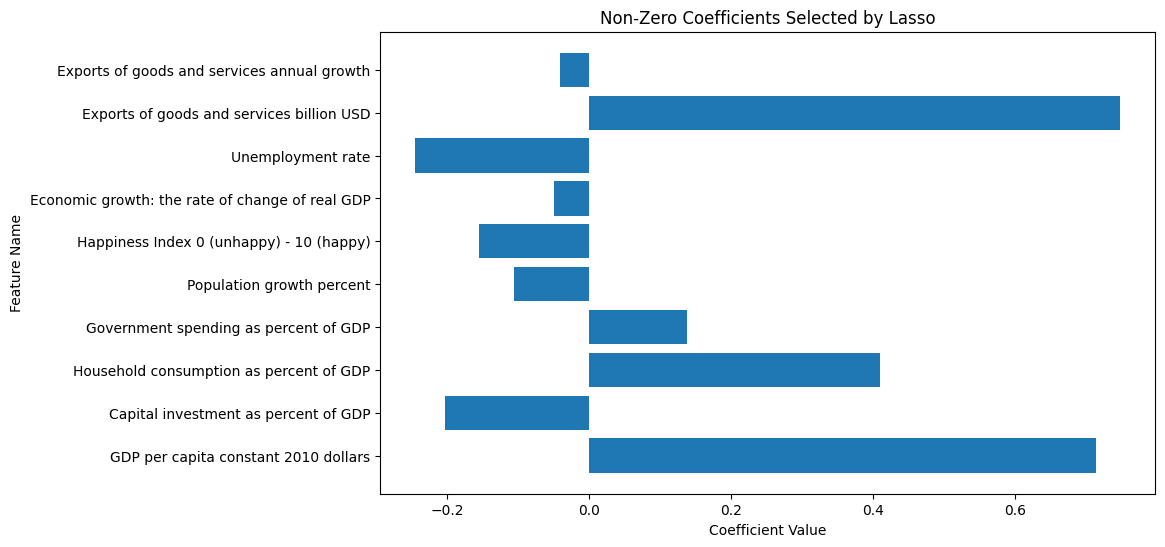

In [18]:
coefs = lasso_cv.coef_
features = X.columns

# Filter out the non-zero coefficients and their corresponding feature names
selected_features = features[coefs != 0]
selected_coefs = coefs[coefs != 0]
unselected_features = features[coefs == 0]
print(f"These features are assigned with 0 coefficient: {unselected_features}")

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_coefs)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Non-Zero Coefficients Selected by Lasso')
plt.show()

In [28]:
y_pred = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.8477545830384928


In [33]:
print(f"Best alpha: {lasso_cv.alpha_}")
coef_dict = {df.columns[i+4]: lasso_cv.coef_[i] for i in range(len(df.columns)-5)}
coefficient_lasso = pd.DataFrame(coef_dict, index=[0])
coefficient_lasso

Best alpha: 0.01823104463683346


,GDP per capita constant 2010 dollars,Capital investment as percent of GDP,Capital investment billion USD,Household consumption as percent of GDP,Household consumption billion USD,Labor force million people,Government spending as percent of GDP,Government spending billion USD,Population growth percent,Happiness Index 0 (unhappy) - 10 (happy),Economic growth: the rate of change of real GDP,Gross Domestic Product billions of 2010 U.S. dollars,Unemployment rate,Exports of goods and services billion USD,Exports of goods and services annual growth,Current account balance billion USD
0,0.714317,-0.202355,0.0,0.410048,-0.0,-0.0,0.138441,0.0,-0.104881,-0.154663,-0.04874,0.0,-0.244355,0.747922,-0.04035,-0.0


## IV Regression

In [35]:
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

### Part 1: Linear regression using variables selected by Lasso

'Capital investment billion USD', 'Household consumption billion USD',
       'Labor force million people', 'Government spending billion USD',
       'Gross Domestic Product billions of 2010 U.S. dollars',
       'Current account balance billion USD'

$ log (Ranking Index) = \beta_0 + \beta_1 (\text{GDP}) + \beta_2 (\text{GDP growth}) + \beta_3 x_3 + \cdots + \beta_n x_n + \varepsilon $

In [37]:
# as the 'Capital investment billion USD' and 'Capital investment as percent of GDP' represents similar things
# and have a relatively high correlation, we kept one of them
X = df[['Exports of goods and services annual growth',
        'Exports of goods and services billion USD',
        'Unemployment rate',
        'Economic growth: the rate of change of real GDP',
        'Happiness Index 0 (unhappy) - 10 (happy)',
        'Population growth percent',
        'Government spending as percent of GDP',
        'Household consumption as percent of GDP',
        'GDP per capita constant 2010 dollars']]

y = df['ranking index']
y_log = np.log(y)

df['const'] = 1
reg1 = sm.OLS(endog = y_log, exog = X, \
    missing='drop')
results = reg1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          ranking index   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              901.3
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                   1.76e-146
Time:                        04:20:48   Log-Likelihood:                         -240.51
No. Observations:                 192   AIC:                                      499.0
Df Residuals:                     183   BIC:                                      528.3
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----

In [39]:
# calculating mse
sqft_lr_model = linear_model.LinearRegression()
sqft_lr_model.fit(X, y_log)
mse = metrics.mean_squared_error(y_log, sqft_lr_model.predict(X))
print(mse)

0.685765364629623


- As we could see from the OLS result table above, the coefficient on the variable 'Gross Domestic Product billions of 2010 U.S. dollars' is -8.911e-05, the associated p-value is 0.304, which is statistically insignificant at the 5% level.
- And the coefficient on the variable 'Economic growth: the rate of change of real GDP' is -0.0014, the associated p-value is 0.959, which is statistically insignificant at the 5% level as well.
- But the coefficient on 'GDP per capita constant 2010 dollars' has a p-value of 0, which is statistically significant at the 5% level.

In [ ]:
# fitted graph

### Part 2: Two-stage least squares (2SLS) regression

- As the OLS model above is likely suffer from endogeneity issues (reverse causality: better university is likely lead to a higher GDP of the country, and omitted variable bias : there are too many variables correlated with both the university ranking of a country and its GDP, and we may not be able to get data and control all of them). Therefore, here we include the 2SLS model to deal with the problem of endogeneity.

- In this model, to test the effect of 'Gross Domestic Product billions of 2010 U.S. dollars' on log of ranking index, the instrument we have chosen is 'Exports of goods and services billion USD', as it satisfies the three conditions for instruments, which are first stage, exogeneity and exclusion.

##### 1. first stage

$$
\text{Gross Domestic Product billions of 2010 U.S. dollars}_i = \delta_0 + \delta_1 \text{Exports of goods and services billion USD}_i + v_i
$$

In [40]:
# test the first stage
results_fs = sm.OLS(df['Gross Domestic Product billions of 2010 U.S. dollars'],
                    df[['const', 'Exports of goods and services billion USD']]).fit()
print(results_fs.summary())

                                             OLS Regression Results                                             
Dep. Variable:     Gross Domestic Product billions of 2010 U.S. dollars   R-squared:                       0.749
Model:                                                              OLS   Adj. R-squared:                  0.747
Method:                                                   Least Squares   F-statistic:                     566.3
Date:                                                  Tue, 28 Nov 2023   Prob (F-statistic):           6.80e-59
Time:                                                          04:27:49   Log-Likelihood:                -1735.8
No. Observations:                                                   192   AIC:                             3476.
Df Residuals:                                                       190   BIC:                             3482.
Df Model:                                                             1                         

- As we see from the table, the coefficient is large and the p-value is 0 which is lower than 0.05, therefore the instrument is correlated with the GDP. -> satisfies the first condition for instrument we mentioned above

- We cannot directly test whether the instrument is correlated with the error term or not (exogeneity and exclusion). But intuitively, the export should not correlated with the ranking index except for the fact that it inflences GDP. As we could see from the QS ranking calculation, none of the considered factors (Sustainability, Employment outcomes, International research network, etc.) seem related to the export of countries. Therefore we could infer export is a viable instrument in this case.

#### 2. second stage

$$
\log(\text{ranking index})_i = \beta_0 + \beta_1 \widehat{\text{GDP}}_i + u_i
$$

In [41]:
df['predicted_gdp'] = results_fs.predict()

results_ss = sm.OLS(y_log,
                    df[['const', 'predicted_gdp']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:          ranking index   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     95.69
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.47e-18
Time:                        04:28:16   Log-Likelihood:                -292.83
No. Observations:                 192   AIC:                             589.7
Df Residuals:                     190   BIC:                             596.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0409      0.095     52.935

#### 3. directly using linearmodels package (IV2SLS)

In [42]:
iv = IV2SLS(dependent = y_log,
            exog = df['const'],
            endog = df['Gross Domestic Product billions of 2010 U.S. dollars'],
            instruments = df['Exports of goods and services billion USD']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          ranking index   R-squared:                      0.2465
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2426
No. Observations:                 192   F-statistic:                    85.351
Date:                Tue, Nov 28 2023   P-value (F-stat)                0.0000
Time:                        04:28:26   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                                  Parameter Estimates                                                   
                                                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------------
const

- the package give us the same coefficient as we get from the first stage second stage analysis, therefore in the next part we directly use the iv package

#### 4. testing the effect of GDP growth on ranking index

- for testing the impact of GDP gowth on log ranking index, we change the instrument to 'Exports of goods and services annual growth'

In [ ]:
# first stage
results_fs = sm.OLS(df['Economic growth: the rate of change of real GDP'],
                    df[['const', 'Exports of goods and services annual growth']]).fit()
print(results_fs.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Economic growth: the rate of change of real GDP   R-squared:                       0.607
Model:                                                         OLS   Adj. R-squared:                  0.605
Method:                                              Least Squares   F-statistic:                     293.3
Date:                                             Mon, 27 Nov 2023   Prob (F-statistic):           2.25e-40
Time:                                                     02:45:26   Log-Likelihood:                -448.93
No. Observations:                                              192   AIC:                             901.9
Df Residuals:                                                  190   BIC:                             908.4
Df Model:                                                        1                                         
Covariance Type:            

In [ ]:
# 2SLS
iv2 = IV2SLS(dependent = y_log,
            exog = df['const'],
            endog = df['Economic growth: the rate of change of real GDP'],
            instruments = df['Exports of goods and services annual growth']).fit(cov_type='unadjusted')

print(iv2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          ranking index   R-squared:                     -0.0023
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0076
No. Observations:                 192   F-statistic:                    2.4150
Date:                Mon, Nov 27 2023   P-value (F-stat)                0.1202
Time:                        02:46:03   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                                Parameter Estimates                                                
                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------------
const               